In [115]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import decimal

### Fonctions générales:

$\to$ On définit la fonction $W(n,P)$ qui génère une matrice $(W_{i,k})$ générée suivant une loi donnée centrée réduite avec $W^i_0 = 0$.



$\to$ On définit la fonction $\texttt{gen_X}(n,X_0,\sigma,\lambda, \delta,P, W)$ qui étant donné à un vecteur à $n$ dimensions de départ $X_0$ simule $P$ pas des actifs $X(P\delta) = (X_1(P\delta), \cdots, X_n(P\delta))$ où l'équation d'évolution est la suivante:
$$X_i(t_{k+1}) = X_i(t_k)e^{-\lambda \delta} + \mu(1-e^{-\lambda \delta})+ \sqrt{\delta} \sigma W_{i,k}  \text{ (équation 1)}$$

$\to$ Pour le cas particulier de $W_k^i$ i.i.d et suit la loi gaussienne centrée réduite, on fait la remarque que pour $k\in [|1,n|]$ et un temps $t_P = T$, $X_k(t_P)$ est somme de gaussiennes indépendantes, on déduit que $X_k(t_P)$ est aussi une variable gaussienne. Les caractéristiques de cette gaussienne se déduisent aisément par la relation de récurrence de l'équations $(1)$, pour $N\in \textbf{N}$, en notant $\mu_{N,k}$ la moyenne de cette gaussienne et $\sigma_{P,k}$ sa variance:
$$\begin{cases}
\mu_{P,k} = e^{-\lambda \delta}\mu + \mu(1-e^{-\lambda \delta})\\
\sigma_{P,k}^2 = e^{-2\lambda\delta}\sigma_{P-1,k}^2+ \delta \sigma^2 
\end{cases}
$$

On résout aisément, on trouve:
$$\mu_{P,k}  = \mu\text{ , }\sigma_{P,k}^2 = r(1-e^{-2P\lambda \delta}) \text{ où }r  =\dfrac{\delta \sigma^2}{1-e^{-2\lambda \delta}}$$
$\to$ On définit alors la fonction $\texttt{gen_X_particulier}(X_0,P,n,\sigma,\lambda, \delta)$ qui renvoie directement le résultat au temps $T$ d'une simulation.


On définit la fonction $\texttt{insolvance_1}(v, C)$ qui étant donné un vecteur $v =X(T)$ des actifs à l'écheance, renvoie la liste des banque insolvante. On fait la remarque suivante:
$$D_{k}^T = D_{k-1}^T\cup ( D_{k}^T -  D_{k-1}^T)$$

$\to$ On définit la fonction impact $I(X_0,P\propto T, F,R)$ où $F$ est le résultat de insolvance_1.

In [142]:
#####Fonctions générales
def W_1(n,P = 365):
    W_1 = np.random.randn(n,P)
    W_1[:, 0]= 0
    return W_1

def gen_X(X_0, W,P = 365, n =5, sigma = 8, lbda = 20, delta =1/365):
    A = np.full((n,P),0.0)
    A[:,0] = X_0
    for p in range(1,P):
        A[:,p] =A[:,p-1]*np.exp(-lbda*delta) + X_0*(1- np.exp(-lbda*delta))+np.sqrt(delta)*sigma *W[:,p]
    return A

def gen_X_particulier(X_0,N=1,P=365,n=5,sigma = 8,lbda = 20, delta = 1/365):
    mu_P =np.tile(X_0,(N,1))
    sigma_2 = delta*sigma**2 *(1-np.exp(-2*P*lbda*delta)) /(1-np.exp(-2*lbda*delta) )
    return X_0+np.sqrt(sigma_2)*np.random.normal(size = (N,1))

def insolvance_1(E,v, C, R = 0.05):
    assert len(v) == len(C)
    assert E.shape[0] == len(v) and E.shape[1] == len(v)
    used_up = np.full(len(v),False)
    l=-1
    while True:
        used_up+= v<C
        v = (v - (1-R)*np.sum(E*(used_up), axis = 1))*(v>=C)
        if (l == np.sum(used_up)):
            break
        l = np.sum(used_up)
    return used_up

def I(X,F,R = 0.05, P = 365):
    return np.sum((X + (1-R)*np.sum(E[~F], axis = 0))*(F))

vectorized_impact = np.vectorize(I, signature='(n),(n)->()')

def calculate_var_cvar(impacts, alpha):
    sorted_impacts=np.sort(impacts)
    #calculons value-at_risk
    var_index=int((1 - alpha) * len(sorted_impacts))
    var=sorted_impacts[var_index]
    #Conditional VAR
    cvar = np.mean(sorted_impacts[var_index:])
    return var, cvar

## Premier modèle: Capitaux indépendants

On s'interesse au calcul de différents quantités probabilisites relatifs aux $X_i$. On utilise les différents méthodes de simulations exposés lors des cours magistraux:

$\to$ Méthode de Monte-Carlo Naif.

$\to$ Méthode d'échantillonage d'importance.

$\to$ Méthode MCMC.

On estime les quantités suivantes:

$\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$, la probabilité qu'on a insolvance d'exactement $k$ banques.

$\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

$\to$ Distribution de l’impact de défaut conditionnellement à l'effondrement du réseaux tout entier.

Pour ce cas particulier, $\textbf{ on utilise que les valeurs finaux de $X$}$, on se sert alors de la fonction $\texttt{gen_X_particulier}$.

#### Paramètres du modèle

On prend $n=5$. On se sert de la fonction $\texttt{gen_X_particulier}$. Plus tard on prend des valeurs assez grande de $n$.

In [117]:
####Constantes
N = 100000 #nombres de simulations
sigma = 8
lbda = 20
delta =1/365

In [118]:
## Hypothèse du premier modèle:
n = 5 
P = 365
sigma_2 = delta*sigma**2 *(1-np.exp(-2*P*lbda*delta)) /(1-np.exp(-2*lbda*delta) )
R = 0.05
E = np.array([[0,3,0,0,6],
              [3,0,0,0,0],
              [3,3,0,0,0],
              [2,2,2,0,2],
              [0,2,3,3,0]])

mu = 15. ## commune
c = 10 ## commune
X_0 = np.full(n,mu)
C = np.full(n,c)

In [119]:
#Génération de de trajectoire de $n = 5$ banques entre $t=0$ et $t=T$
W = W_1(n)
X = gen_X(X_0,W)

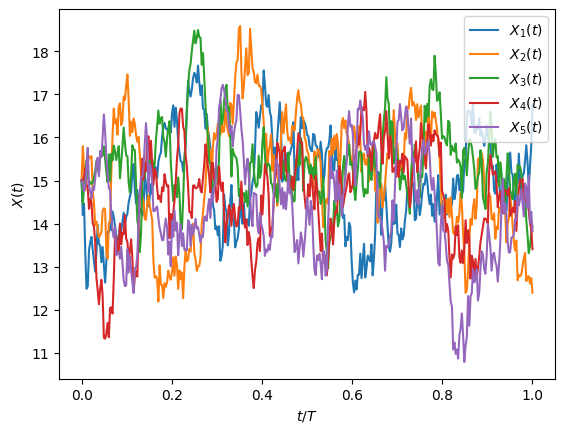

In [120]:
#Visualisation
base = np.linspace(0,1, num =X.shape[1])
for j in range(X.shape[0]):
    plt.plot(base,X[j,:], label = '$X_'+str(j+1)+'(t)$')
plt.xlabel("$t/T$")
plt.ylabel('$X(t)$')
leg = plt.legend(loc=0)
plt.show()

## $\blacktriangleright$ Monte-Carlo Naif

In [121]:
## Génération de $N$ trajectoires de $X$.
echantillons = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
impacts = vectorized_impact(echantillons, insolvances)

### $\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$.

On a $|D_n^T|= |D_n^T|(X)$ et donc pour des $(X_i)$ i.i.d, on a à $k$ fixé par TCL+Slutsky et LFN:
$$\overline{c}_k^N = \dfrac{1}{N}\sum_{k=1}^N \overbrace{\textbf{1}_{|D_n^T|(X_i)= k}}^{\text{i.i.d dans }\{0,1\}\text{, admet donc tous moment}}\xrightarrow[N\to +\infty]{}\textbf{P}(|D_n^T|(X)= k) =p_k$$
$$\dfrac{\sqrt{N}}{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}(\overline{c}_k^N - p_k)\xrightarrow[N\to +\infty]{\mathcal{L}}\mathcal{N}(0,1)$$
On obtient un intervalle de confiance, en notant $q$ la quantile d'ordre $0.95$ de la loi normale:
$$p_k \in[\overline{c}_k^N - \rho^N_k ,\overline{c}_k^N + \rho^N_k] \text{ où }\rho^N_k = q \dfrac{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}{\sqrt{N}}$$

Probabilités {0: 0.99993, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 7e-05}
Longueur des intervalles de confiance {0: 4.351721321773638e-05, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 4.351721321773188e-05}


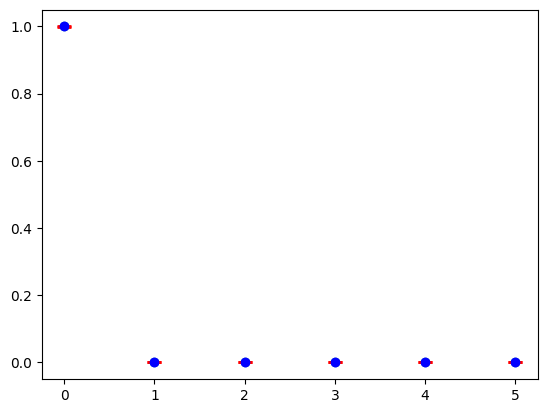

In [122]:
## Génération de $N$ valeurs finaux de $X$ pour chaque k
probas = np.bincount(cardinaux, minlength = n+1)/N
q = stats.norm.ppf(0.95)
var = q *np.sqrt(probas*(1-probas))/np.sqrt(N)
plt.scatter(np.arange(n+1), probas)
plt.errorbar(np.arange(n+1),probas, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()
print('Probabilités', dict(zip(np.arange(n+1), probas)))
print('Longueur des intervalles de confiance', dict(zip(np.arange(n+1), var)))

### $\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

In [123]:
##Simulation de nbr*N_reduit simulations
alphas = np.linspace(0.99, 1, num = 10)
nbr = 10
varL = np.full((nbr, alphas.shape[0]),0)
cvarL = np.full((nbr, alphas.shape[0]),0)
for nb in range(nbr):
    echantillons = gen_X_particulier(X_0,N)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    impacts = vectorized_impact(echantillons, insolvances)
    for i in range(len(alphas)):
        alpha = alphas[i]
        var, cvar = calculate_var_cvar(impacts, alpha)
        varL[nb,i] = var
        cvarL[nb,i] = cvar

[]

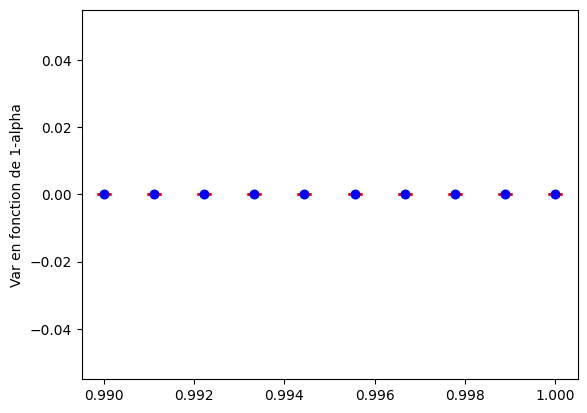

In [124]:
varA = np.mean(varL,axis = 0)
varvar = np.var(varL, axis =0)
plt.scatter(alphas, varA)
plt.errorbar(alphas,varvar, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('Var en fonction de 1-alpha')
plt.plot()

[]

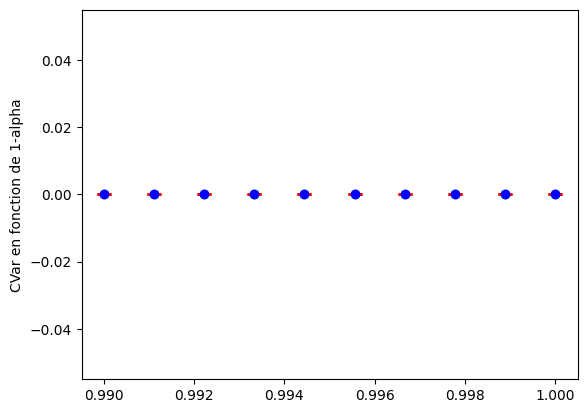

In [125]:
cvarLA =np.mean(cvarL,axis = 0)
varvarLA = np.var(cvarL, axis =0)
plt.scatter(alphas, cvarLA)
plt.errorbar(alphas,varvarLA, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('CVar en fonction de 1-alpha')
plt.plot()


In [126]:
## Distribution de I(T) condtionnelle
dist = impacts[cardinaux == n]

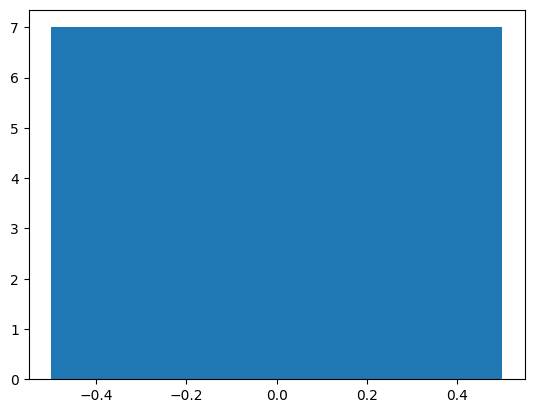

In [127]:
plt.hist(dist, bins='auto')
plt.show()

En ce basant sur ces résultats, la méthode de Monte Carlo $\textbf{n'est pas suffisante}$. Nous optons pour d'autre méthodes dite de réduction de variance, comme suit:

## $\blacktriangleright$ Échantillonage d'importance (Importance splitting)

L'idée est utiliser l'échantillonage par importance avec une distribution de telle manière à augmenter la probabilité que $|D_n^T|$ prennent des valeurs elevées, on propose de réduire $\mu$ en $\mu'$ de telle manière qu'il y'a plusieurs fois la réalisation de $X_i\leq c_i$. On pose alors:
$$X' \hookrightarrow \mathcal{N}\bigg(\mu' I_n, \dfrac{\delta \sigma^2}{1- e^{-2\lambda \delta}} (1- e^{-\lambda T}) I_n\bigg) $$
On note $f^n_{\mu, \sigma}$ la densité de la loi $\mathcal{N}(\mu I_n, \sigma^2 I_n)$. On a alors:
$$\textbf{P}(|D_n^T| = k) = \textbf{E}_X\bigg[\textbf{1}_{|D_n^T|(X) = k}\bigg] =  \textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \dfrac{f^n_{\mu, \sigma_N}(X)}{f^n_{\mu', \sigma_N}(X')}\bigg]=\textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \cdot \text{exp}\bigg(\dfrac{\sum_{i=1}^n (X'_i-\mu')^2 -(X'_i-\mu)^2  )}{2\sigma_N^2}\bigg)\bigg]$$

In [128]:
### Recherche empirique d'un mu prime optimal
mu_primes = np.linspace(min(C)-1,mu+1,num = 500 )
d_mu_p = np.full_like(mu_primes,0) 
cards = np.full_like(mu_primes,0) 
for i in range(len(mu_primes)):
    mu_prime = mu_primes[i]
    Xp_0 =np.full(n,mu_prime)
    echantillons = gen_X_particulier(Xp_0,10000)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
    d_mu_p[i] = np.mean(cardinaux)
    cards[i] = len(np.unique(cardinaux))/(n+1)
plt.plot(mu_primes, d_mu_p)
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.scatter(mu_primes, cards)
plt.show()

On prend $\mu' = 11$. On envisage le problème calculatoire suivant:

In [129]:
mu_p=11
Xp_0 =np.full(n,mu_p)
echantillons = gen_X_particulier(Xp_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux  = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
classes = np.full(n+1,0)
for i in range(echantillons.shape[0]):
    norm_dec= decimal.Decimal((np.sum(((echantillons[i] - Xp_0 )**2 - (echantillons[i]-X_0)**2))/(2*sigma_2)))
    classes[cardinaux[i]] += norm_dec.exp()
print(classes/N)

OverflowError: Python int too large to convert to C long

In [130]:
echantillons=gen_X_particulier(X_0,100000)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)

Du aux erreurs d'arrondissement, nous avons décidé d'appliquer l'échantillonage d'importance à la variance au lieu de la moyenne 

In [145]:

# Given parameters
K = 20000  # Number of simulations
T = 1
mu = 15


# Calculate sigma_2
sigma_2 = delta * sigma**2 * (1 - np.exp(-lbda * T)) / (1 - np.exp(-2 * lbda * delta))
sigma_p = sigma_2 + 2
facteur = 1 / sigma_p - 1 / sigma_2

# Initialize probabilities
probas = np.zeros(n + 1)

# Generate random samples
X = np.random.normal(loc=mu, scale=np.sqrt(sigma_p), size=(K, n))



# Calculate insolvencies
insolvances = np.apply_along_axis(lambda v: insolvance_1(E, v, C, R), axis=1, arr=X)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis=1, arr=insolvances)

# Calculate probabilities
for k in range(K):
    r = cardinaux[k]
    probas[r] += np.exp(0.5 * facteur * np.sum((X[k] - mu)**2))

# Normalize probabilities
adjustment_factor = (sigma_p / sigma_2)**(5 / 2)
probas = adjustment_factor * probas / K


print(f"Probabilities of having {np.arange(n + 1)} insolvent banks: {probas}")
print(f"Sum of probabilities: {np.sum(probas)}")


Probabilities of having [0 1 2 3 4 5] insolvent banks: [9.93522522e-01 2.64919979e-04 9.97977836e-06 6.01537600e-06
 3.01982703e-06 5.81302278e-05]
Sum of probabilities: 0.993864586696644


In [ ]:
## Génération de $N$ trajectoires de $X$.
echantillons = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
impacts = vectorized_impact(echantillons, insolvances)

In [ ]:
def adapted_impact(x, F):
     return  I(x,F) +np.sum(mu-x[~F])
X = gen_X_particulier(X_0,10)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
vectorized_adapted_impact = np.vectorize(adapted_impact, signature='(n),(n)->()')
A = vectorized_adapted_impact(X,insolvances)


In [ ]:
#Adaptative spliiting sur P(I(T)>a) 




def adapted_impact(x, F):
    return I(x,F)  +np.sum(mu-x[~F]) 

vectorized_adapted_impact = np.vectorize(adapted_impact, signature='(n),(n)->()')
def transformation_sur_quantile(x,quantile,rho,M):
    rho_bar=np.sqrt(1-rho**2)
    y=np.random.randn(M,len(x))
    for i in range(M):
        xtilde = rho*x+sigma*rho_bar*y[i]+mu*(1-rho)
        F=insolvance_1(E,xtilde,C,R)
        si=adapted_impact(xtilde, F)>quantile
        x = xtilde*(si) + x*(not si)
    return x


def NiveauxSplitting(a, seuil, rho, N, M, c , E , R):
    X = gen_X_particulier(X_0,N)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
    impacts = vectorized_adapted_impact(X, insolvances)
    I_brut=impacts.copy() #On conserve la liste I non-triée
    impacts.sort()
    
    quantiles = np.array([])
    indice = int(np.ceil((1-seuil)*N))-1
    print("indice",indice)
    quantiles = np.append(quantiles, impacts[indice])
    print("quantile:" , quantiles)
    quantile=quantiles[-1]
    while quantiles[-1] < a:
        initial=len(X)
        indices = I_brut>quantiles[-1] 
        X = X[indices]
        print(initial-len(X))
        sous_X= []
        for i in range (initial-len(X)):
            j=np.random.randint(0,len(X))
            sous_X.append(X[j])
        Z= [transformation_sur_quantile(x, quantiles[-1], rho, M) for x in sous_X]
        X = np.concatenate((X, Z), axis=0)  
        insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
        cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
        impacts = vectorized_adapted_impact(X, insolvances)
        print(impacts.shape)
        I_brut=impacts.copy() #On conserve la liste I non-triée
        impacts.sort()
        indice=int(np.ceil((1-seuil)*N))-1
        quantiles = np.append(quantiles, impacts[indice])
        print("hh",indice)
        
    print("\n valeurs successives des niveaux")
    print(quantiles)
    ## On rajoute a
    niveaux = np.append(quantiles, a)
    ## Dernière probabilité :
    plast = np.mean(impacts>a)
    return niveaux, plast



a=40
rho=0.5
rho_bar=np.sqrt(1-rho**2)
M=20
m=15
sigma=np.sqrt(sigma_2)


seuil=0.1
print("On cherche les niveaux de splitting approximatifs... \n")   

N=int(10e2) 
niveaux,plast = NiveauxSplitting(a,seuil,rho,N,20,c,E,R)
print("Nombre de niveaux ={}:".format(len(niveaux)-1)) 



print("-"*40)
Proba_emp_split=plast*seuil**(len(niveaux)-1)


# estimateur Monte-Carlo naif

X = gen_X_particulier(X_0,N*100)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
impacts = vectorized_adapted_impact(X, insolvances)
Proba_emp_MonteCarlo=np.mean(impacts>a)

print("--"*40)
print("Splitting method gives = {:1.3e}".format(Proba_emp_split))
print("Simple Monte-Carlo gives = {:1.3e}".format(Proba_emp_MonteCarlo))

In [ ]:
def transformation_quantile(X,quantile,rho,M):
    rho_bar=np.sqrt(1-ro**2)
    Y=np.random.randn(M,len(X))
    for i in range(M):
        Xtilde = rho*X+sigma*rho_bar*Y[i]+mu*(1-rho)
        si=adapted_impact(Xtilde, c, E, R)>quantile
        X = Xtilde*(si) + X*(not si)
  
    return X


def adapted_impact(X, c, E, R):
    return impact(X, c, E, R)+np.sum(mu-X[i]) 
    

def NiveauxSplitting(a, seuil, rho, n, M, c , E , R):
    X = np.random.randn(n*5)
    X=X.reshape(n,5)
    X=sigma*X+mu   
    I=np.array([adapted_impact(x,c,E,R) for x in X])
    I_brut=I # On conserve la liste I non-triée
    I.sort()
    print('min(I):', min(I))
    quantiles = np.array([])
    indice = int(np.ceil((1-seuil)*n))-1
    print("indice",indice)
    quantiles = np.append(quantiles, I[indice])
    print("quantile:" , quantiles)

    while quantiles[-1] < a:
        initial=len(X)

        indices = [adapted_impact(x,c,E,R)>quantiles[-1] for x in X]
        X = X[indices]
        print(initial-len(X))
        sous_X= []
        for i in range (initial-len(X)):
            j=np.random.randint(0,len(X))
            sous_X.append(X[j])
        
        Z = np.array([transformation_quantile(x, quantiles[-1], rho, M) for x in sous_X])
        print("ssss",np.min(I))
        X = np.concatenate((X, Z), axis=0)  
        I = np.array([adapted_impact(x,c,E,R) for x in X])
        indice=int(np.ceil((1-seuil)*n))-1
        print("start",np.min(I))
        print("end", I[indice])
        I_brut=I # On conserve la liste I non-triée
        I.sort()
        quantiles = np.append(quantiles, I[indice])
        
    

    ## On affiche les niveaux a_1, a_2,... strictement en dessous de a
    quantiles = quantiles[:-1]
    print("\n valeurs successives des niveaux")
    print(quantiles)
    ## On rajoute a
    niveaux = np.append(quantiles, a)
    ## Dernière probabilité :
    I = np.array([adapted_impact(x,c,E,R) for x in X])
    plast = np.mean(I>a)
    return niveaux, plast


## Parametres du probleme. 
## ATTENTION : si a grand et rho petit (ex. rho=0.1) 
## pbme sur le calcul des derniers niveaux car la chaine n'accepte quasiment plus
a=20
rho=0.5
rho_bar=np.sqrt(1-rho**2)
M=20
m=15
sigma=np.sqrt(sigma_N2)


seuil=0.1
print("On cherche les niveaux de splitting approximatifs... \n")   

n=int(10e2) 
niveaux,plast = NiveauxSplitting(a,seuil,rho,n,M,c,E,R)
print("Nombre de niveaux ={}:".format(len(niveaux)-1)) 



print("-"*40)
Proba_emp_split=plast*seuil**(len(niveaux)-1)


# estimateur Monte-Carlo naif

X=np.random.randn(n*100*5)
X = X.reshape(n*100,5)
X=sigma*X+mu
I = np.array([adapted_impact(x,c,E,R) for x in X])
Proba_emp_MonteCarlo=np.mean(I>a)


print("--"*40)
print("Splitting method gives = {:1.3e}".format(Proba_emp_split))
print("Simple Monte-Carlo gives = {:1.3e}".format(Proba_emp_MonteCarlo))
